<a href="https://colab.research.google.com/github/Debadri3/cnn-electric-guitar-classification/blob/master/guitarclassoipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # At time of recording, TF 2.x is not the default
import tensorflow as tf
print("TF version:", tf.__version__)

TF version: 2.2.0


In [2]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

# Check for GPU
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.2.0
Hub version: 0.8.0
GPU available (YESS!!!!)


In [3]:
# Running this cell will provide you with a token to link your drive to this notebook
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/all guitars/guitars.csv")
print(labels_csv.describe())
print(labels_csv.head())

                   image-       label-
count                 653          653
unique                653            7
top     Les Paul (64).jpg  Super Strat
freq                    1          100
                   image-               label-
0    Stratocaster (1).jpg  Fender Stratocaster
1   Stratocaster (10).jpg  Fender Stratocaster
2  Stratocaster (100).jpg  Fender Stratocaster
3   Stratocaster (11).jpg  Fender Stratocaster
4   Stratocaster (12).jpg  Fender Stratocaster


In [5]:
len(labels_csv)

653

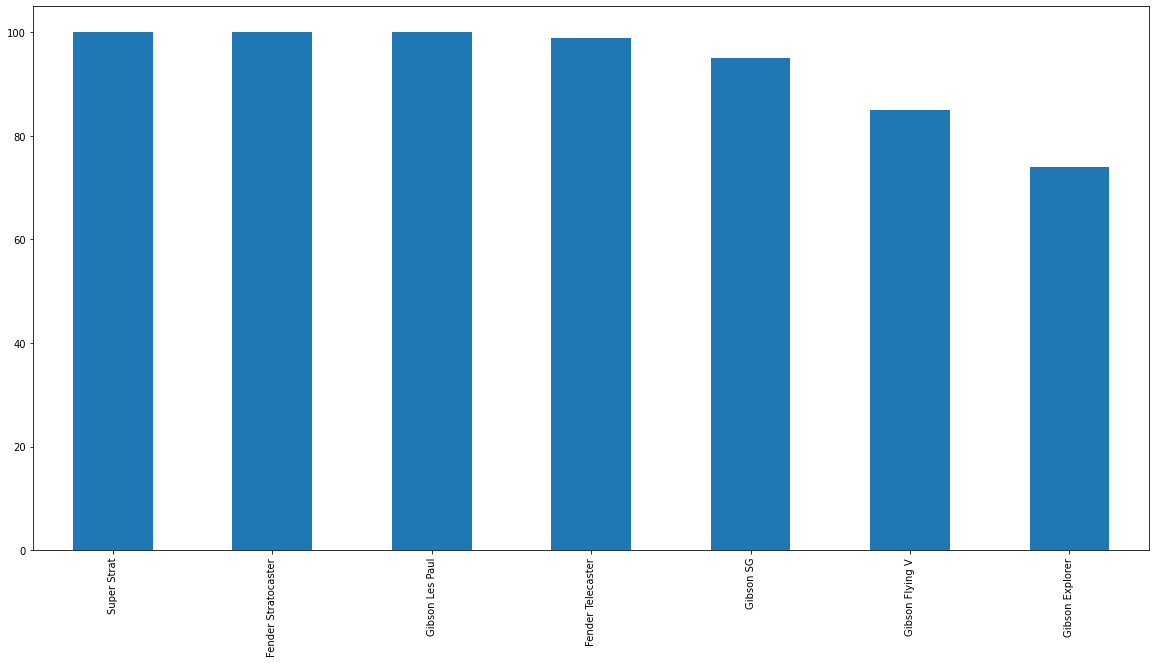

In [6]:
# How many images are there of each breed?
labels_csv["label-"].value_counts().plot.bar(figsize=(20, 10));

Okay sweet. If we were to roughly draw a line across the middle of the graph, we'd see there's about 70+ images for each guitar model.

This is a good amount as for some of their vision products [Google recommends a minimum of 10 images per class to get started](https://cloud.google.com/vision/automl/object-detection/docs/prepare). And as you might imagine, the more images per class available, the more chance a model has to figure out patterns between them.

Let's check out one of the images.



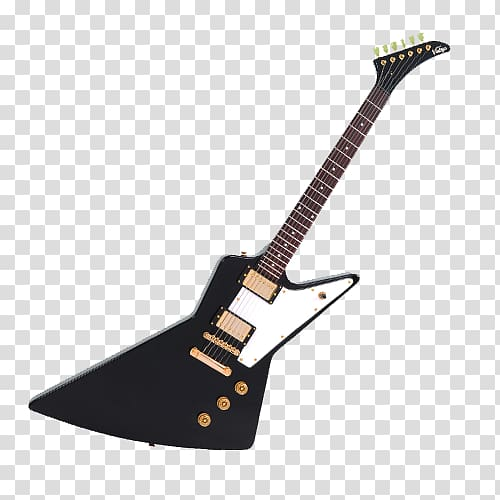

In [7]:
from IPython.display import display, Image
Image("drive/My Drive/all guitars/Explorer (1).jpg")

### Getting images and their labels

Since we've got the image ID's and their labels in a DataFrame (`labels_csv`), we'll use it to create:
* A list a filepaths to training images
* An array of all labels
* An array of all unique labels

We'll only create a list of filepaths to images rather than importing them all to begin with. This is because working with filepaths (strings) is much efficient than working with images.

In [8]:
# Create pathnames from image ID's
filenames = ["drive/My Drive/all guitars/" + fname for fname in labels_csv["image-"]]

# Check the first 10 filenames
filenames[:10]

['drive/My Drive/all guitars/Stratocaster (1).jpg',
 'drive/My Drive/all guitars/Stratocaster (10).jpg',
 'drive/My Drive/all guitars/Stratocaster (100).jpg',
 'drive/My Drive/all guitars/Stratocaster (11).jpg',
 'drive/My Drive/all guitars/Stratocaster (12).jpg',
 'drive/My Drive/all guitars/Stratocaster (13).jpg',
 'drive/My Drive/all guitars/Stratocaster (14).jpg',
 'drive/My Drive/all guitars/Stratocaster (15).jpg',
 'drive/My Drive/all guitars/Stratocaster (16).jpg',
 'drive/My Drive/all guitars/Stratocaster (17).jpg']

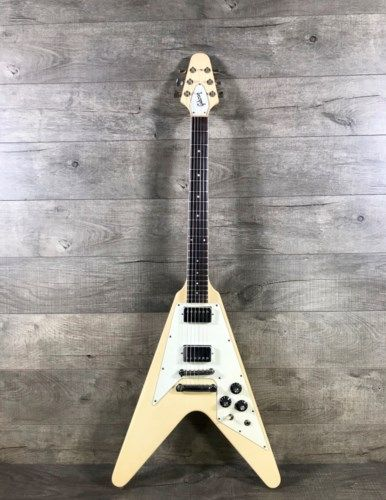

In [9]:
# Check an image directly from a filepath
Image(filenames[300])

In [10]:

len(filenames)

653



We'll take them from `labels_csv` and turn them into a NumPy array.

In [11]:
import numpy as np
labels = labels_csv["label-"].to_numpy() # convert labels column to NumPy array
labels[:10]

array(['Fender Stratocaster', 'Fender Stratocaster',
       'Fender Stratocaster', 'Fender Stratocaster',
       'Fender Stratocaster', 'Fender Stratocaster',
       'Fender Stratocaster', 'Fender Stratocaster',
       'Fender Stratocaster', 'Fender Stratocaster'], dtype=object)

Wonderful, now lets do the same thing as before, compare the amount of labels to number of filenames.

In [12]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories.")

Number of labels matches number of filenames!


In [13]:
# Find the unique label values
unique_labels = np.unique(labels)
len(unique_labels)

7

We are working with 7 guitar models.

In [14]:
# Example: Turn one label into an array of booleans
print(labels[0])
labels[0] == unique_labels # use comparison operator to create boolean array

Fender Stratocaster


array([ True, False, False, False, False, False, False])

That's for one example, let's do the whole thing.

In [15]:
# Turn every label into a boolean array
boolean_labels = [label == np.array(unique_labels) for label in labels]
boolean_labels[:2]

[array([ True, False, False, False, False, False, False]),
 array([ True, False, False, False, False, False, False])]

In [16]:
# Example: Turning a boolean array into integers
print(labels[0]) # original label
print(np.where(unique_labels == labels[0])[0][0]) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

Fender Stratocaster
0
0
[1 0 0 0 0 0 0]


Wonderful! Now we've got our labels in a numeric format and our image filepaths easily accessible (they aren't numeric yet), let's split our data up.

### Creating our own validation set



In [0]:
# Setup X & y variables
X = filenames
y = boolean_labels

Now let's split our data into training and validation sets. We'll use and 80/20 split (80% training data, 20% validation data).

In [18]:
# Import train_test_split from Scikit-Learn
from sklearn.model_selection import train_test_split

# Split them into training and validation using NUM_IMAGES 
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y, 
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(522, 522, 131, 131)

In [19]:
# Check out the training data (image file paths and labels)
X_train[:5], y_train[:2]

(['drive/My Drive/all guitars/Super Strat (45).jpg',
  'drive/My Drive/all guitars/Les Paul (51).jpg',
  'drive/My Drive/all guitars/Stratocaster (35).jpg',
  'drive/My Drive/all guitars/Flying V (21).jpg',
  'drive/My Drive/all guitars/Explorer (2).jpg'],
 [array([False, False, False, False, False, False,  True]),
  array([False, False, False, False,  True, False, False])])

### Preprocessing images (turning images into Tensors)

Our labels are in numeric format but our images are still just file paths.

Since we're using TensorFlow, our data has to be in the form of Tensors.

A Tensor is a way to represent information in numbers. If you're familar with NumPy arrays (you should be), a Tensor can be thought of as a combination of NumPy arrays, except with the special ability to be used on a GPU.

Because of how TensorFlow stores information (in Tensors), it allows machine learning and deep learning models to be run on GPUs (generally faster at numerical computing).

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Takes an image filename as input.
2. Uses TensorFlow to read the file and save it to a variable, `image`.
3. Turn our `image` (a jpeg file) into Tensors.
4. Resize the `image` to be of shape (224, 224).
5. Return the modified `image`.

A good place to read about this type of function is the [TensorFlow documentation on loading images](https://www.tensorflow.org/tutorials/load_data/images). 

You might be wondering why (224, 224), which is (heigh, width). It's because this is the size of input our model (we'll see this soon) takes, an image which is (224, 224, 3).

What? Where's the 3 from? We're getting ahead of ourselves but that's the number of colour channels per pixel, red, green and blue.

Let's make this a little more concrete.


In [20]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42]) # read in an image
image.shape

(300, 168, 3)

Notice the shape of `image`. It's (257, 350, 3). This is height, width, colour channel value. 

And you can easily convert it to a Tensor using [`tf.constant()`](https://www.tensorflow.org/api_docs/python/tf/constant).

In [21]:
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 168, 3), dtype=uint8, numpy=
array([[[ 0, 27, 48],
        [14, 41, 62],
        [18, 45, 66],
        ...,
        [13, 38, 60],
        [13, 38, 60],
        [12, 37, 59]],

       [[ 0, 27, 48],
        [14, 41, 62],
        [18, 45, 66],
        ...,
        [12, 39, 60],
        [12, 39, 60],
        [12, 39, 60]]], dtype=uint8)>

Ok, now let's build that function we were talking about.

In [0]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

### Creating data batches



In [0]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

Now we've got a simple function to turn our image file path names and their associated labels into tuples (we can turn these into Tensors next), we'll create a function to make data batches.

Because we'll be dealing with 3 different sets of data (training, validation and test), we'll make sure the function can accomodate for each set.

We'll set a default batch size of 32 because [according to Yann Lecun](https://twitter.com/ylecun/status/989610208497360896?s=20) (one of the OG's of deep learning), friends don't let friends train with batch sizes over 32.

In [0]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [25]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [26]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 7), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 7), dtype=tf.bool, name=None)))

Look at that! We've got our data in batches, more specifically, they're in Tensor pairs of (images, labels) ready for use on a GPU.

But having our data in batches can be a bit of a hard concept to understand. Let's build a function which helps us visualize what's going on under the hood.

### Visualizing data batches

In [0]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_labels[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")

To make computation efficient, a batch is a tighly wound collection of Tensors.

So to view data in a batch, we've got to unwind it.

We can do so by calling the [`as_numpy_iterator()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#as_numpy_iterator) method on a data batch.

This will turn our a data batch into something which can be iterated over.

Passing an iterable to [`next()`](https://docs.python.org/3/library/functions.html#next) will return the next item in the iterator.

In our case, next will return a batch of 32 images and label pairs.

**Note:** Running the cell below and loading images may take a little while.

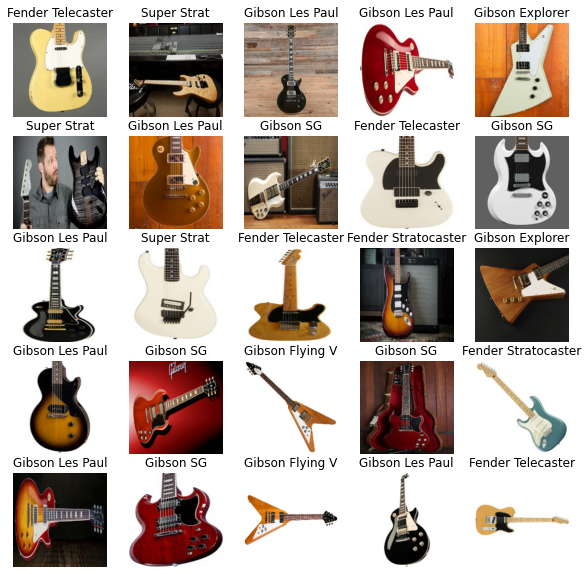

In [28]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

Look at all those beautiful dogs!

**Question:** Rerun the cell above, why do you think a different set of images is displayed each time you run it?

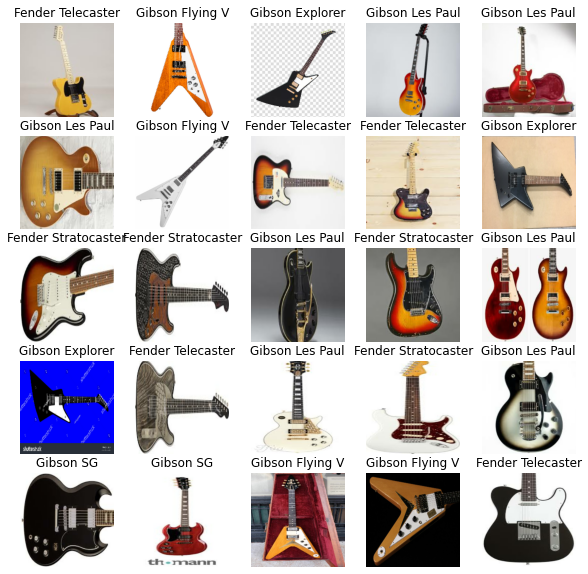

In [29]:
# Visualize validation images from the validation data batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

Even more dogs!

**Question:** Why does running the cell above and viewing validation images return the same dogs each time?

# Creating and training a model





In [0]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_labels) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL ="https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/4"

In [31]:
import tensorflow as tf
from keras.layers import Dropout
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
 print("Building model with:", MODEL_URL)

  # Setup the model layers
 model = tf.keras.Sequential([hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
 tf.keras.layers.Dropout(0.2),
 tf.keras.layers.Dense(units=OUTPUT_SHAPE,activation="softmax") # Layer 2 (output layer)
])
  

  # Compile the model
 model.compile(
 loss=tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
 optimizer=tf.keras.optimizers.Adam(), # A friend telling our model how to improve its guesses
 metrics=["accuracy"] # We'd like this to go up
  )

  # Build the model
 model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting
  
 return model

Using TensorFlow backend.


In [32]:
# Create a model and check its details
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  6158505   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  7014      
Total params: 6,165,519
Trainable params: 7,014
Non-trainable params: 6,158,505
_________________________________________________________________


The non-trainable parameters are the patterns learned by `mobilenet_v2_130_224` and the trainable parameters are the ones in the dense layer we added.

This means the main bulk of the information in our model has already been learned and we're going to take that and adapt it to our own problem.

### Creating callbacks



In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [0]:
import datetime
import os

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Data/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

#### Early Stopping Callback




In [0]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) # stops after 3 rounds of no improvements

### Training a model (on a subset of data)


Along with this, let's quickly check if we're still using a GPU.

In [36]:
# Check again if GPU is available (otherwise computing will take a looooonnnnggggg time)
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU available (YESS!!!!)


In [0]:
# How many rounds should we get the model to look through the data?
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [0]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping])
  
  return model

In [39]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/4
Epoch 1/100
17/17 [==============================] - 8s 456ms/step - loss: 2.0334 - accuracy: 0.2510 - val_loss: 1.3449 - val_accuracy: 0.5344
Epoch 2/100
17/17 [==============================] - 6s 370ms/step - loss: 1.2396 - accuracy: 0.5307 - val_loss: 1.0476 - val_accuracy: 0.6336
Epoch 3/100
17/17 [==============================] - 6s 357ms/step - loss: 0.8907 - accuracy: 0.6628 - val_loss: 0.9042 - val_accuracy: 0.6641
Epoch 4/100
17/17 [==============================] - 6s 364ms/step - loss: 0.6861 - accuracy: 0.7625 - val_loss: 0.8225 - val_accuracy: 0.7023
Epoch 5/100
17/17 [==============================] - 6s 365ms/step - loss: 0.6051 - accuracy: 0.8027 - val_loss: 0.7702 - val_accuracy: 0.7252
Epoch 6/100
17/17 [==============================] - 6s 362ms/step - loss: 0.5177 - accuracy: 0.8429 - val_loss: 0.7399 - val_accuracy: 0.7176
Epoch 7/100
17/17 [==============================

In [40]:
%tensorboard --logdir drive/My\ Drive/Data/logs


<IPython.core.display.Javascript object>

## Making and evaluating predictions using a trained model



In [41]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1) # verbose shows us how long there is to go
predictions

5/5 [==============================] - 1s 279ms/step


array([[1.69784293e-01, 5.36028922e-01, 6.33703219e-03, 2.31848191e-03,
        1.99324787e-02, 3.58364992e-02, 2.29762316e-01],
       [5.89739386e-07, 2.70637189e-04, 2.82519474e-03, 9.96753991e-01,
        4.94499727e-05, 4.05180472e-05, 5.94949452e-05],
       [5.42615271e-05, 5.53476239e-05, 9.98896480e-01, 6.20739826e-04,
        2.94005640e-05, 3.66918066e-05, 3.07078444e-04],
       [1.22621434e-03, 2.50129076e-03, 2.08499856e-04, 1.39962765e-03,
        9.81922030e-01, 9.20218788e-03, 3.54006374e-03],
       [1.89636927e-02, 2.60049338e-03, 8.17142194e-04, 1.05347566e-03,
        5.13401270e-01, 4.38415825e-01, 2.47481093e-02],
       [2.23357249e-02, 7.29033232e-01, 3.60340811e-03, 2.15600757e-03,
        1.52340040e-01, 5.00224307e-02, 4.05090898e-02],
       [5.10521466e-04, 3.06160568e-04, 1.63944289e-01, 8.32756042e-01,
        6.02784043e-04, 3.66396707e-05, 1.84358947e-03],
       [4.02762219e-02, 5.33554733e-01, 4.37270338e-03, 7.07902247e-03,
        4.69494499e-02, 2

In [42]:
# Check the shape of predictions
predictions.shape

(131, 7)

In [43]:
# First prediction
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {unique_labels[np.argmax(predictions[0])]}") # the predicted label

[0.1697843  0.5360289  0.00633703 0.00231848 0.01993248 0.0358365
 0.22976232]
Max value (probability of prediction): 0.5360289216041565
Sum: 1.0
Max index: 1
Predicted label: Fender Telecaster


In [44]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_labels[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'Fender Telecaster'

Wonderful! Now we've got a list of all different predictions our model has made, we'll do the same for the validation images and validation labels.

Remember, the model hasn't trained on the validation data, during the `fit()` function, it only used the validation data to evaluate itself. So we can use the validation images to visually compare our models predictions with the validation labels.

Since our validation data (`val_data`) is in batch form, to get a list of validation images and labels, we'll have to unbatch it (using [`unbatch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#unbatch)) and then turn it into an iterator using [`as_numpy_iterator()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#as_numpy_iterator).

Let's make a small function to do so.

In [45]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_labels[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.7686275 , 0.7490196 , 0.7254902 ],
         [0.7686275 , 0.7490196 , 0.7254902 ],
         [0.7686275 , 0.7490196 , 0.7254902 ],
         ...,
         [0.7803922 , 0.7607844 , 0.7372549 ],
         [0.7803922 , 0.7607844 , 0.7372549 ],
         [0.7803922 , 0.7607844 , 0.7372549 ]],
 
        [[0.7686275 , 0.7490196 , 0.7254902 ],
         [0.7686275 , 0.7490196 , 0.7254902 ],
         [0.7686275 , 0.7490196 , 0.7254902 ],
         ...,
         [0.7803922 , 0.7607844 , 0.7372549 ],
         [0.7803922 , 0.7607844 , 0.7372549 ],
         [0.7803922 , 0.7607844 , 0.7372549 ]],
 
        [[0.7686275 , 0.7490196 , 0.7254902 ],
         [0.7686275 , 0.7490196 , 0.7254902 ],
         [0.7686275 , 0.7490196 , 0.7254902 ],
         ...,
         [0.7803922 , 0.7607844 , 0.7372549 ],
         [0.7803922 , 0.7607844 , 0.7372549 ],
         [0.7803922 , 0.7607844 , 0.7372549 ]],
 
        ...,
 
        [[0.82745105, 0.8078432 , 0.7843138 ],
         [0.82745105, 0.8078432 , 0.78431

Nailed it!

Now we've got ways to get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some functions to make these all a bit more visualize.

More specifically, we want to be able to view an image, its predicted label and its actual label (true label).

The first function we'll create will:
* Take an array of prediction probabilities, an array of truth labels, an array of images and an integer.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and target image on a single plot.

In [0]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  
  # Get the pred label
  pred_label = get_pred_label(pred_prob)
  
  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

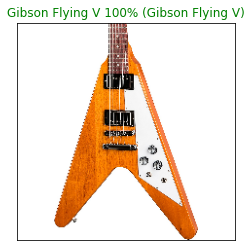

In [47]:
# View an example prediction, original image and truth label
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images)

In [0]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with
  the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_labels[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                     top_10_pred_values, 
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

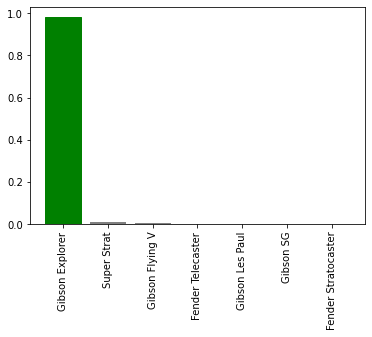

In [49]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

Wonderful! Now we've got some functions to help us visualize our predictions and evaluate our model, let's check out a few.

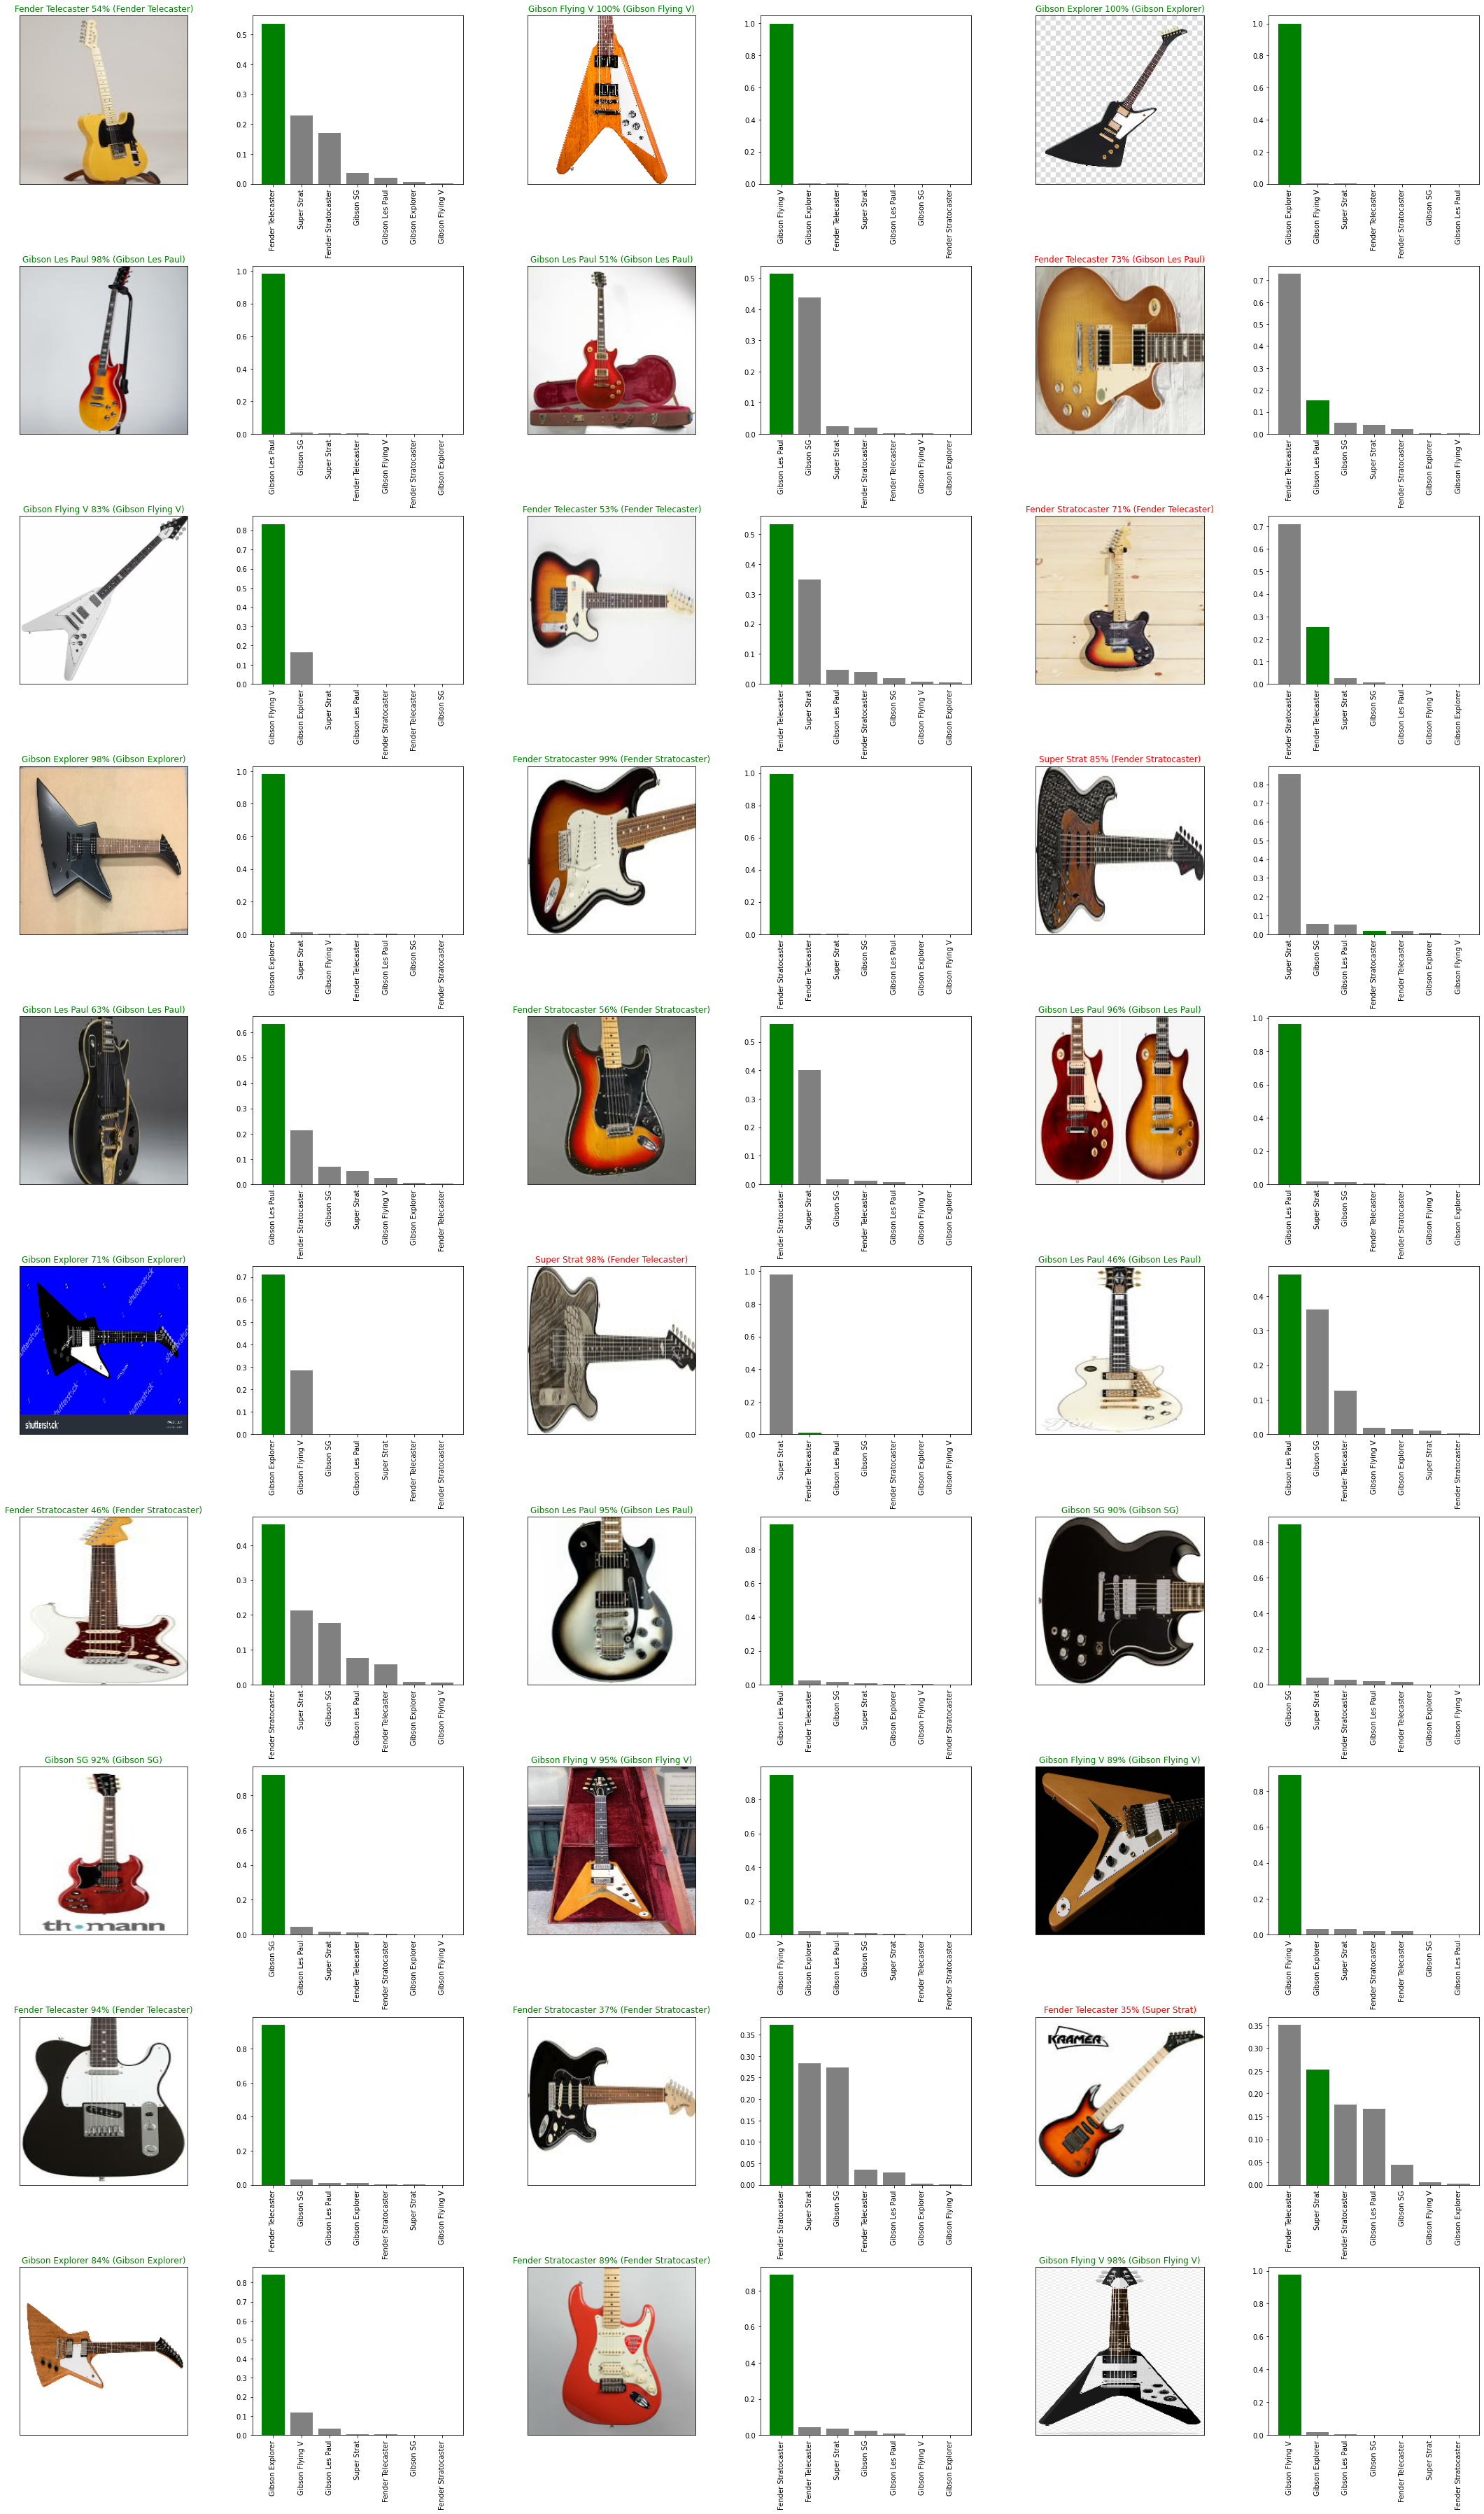

In [0]:
# Let's check a few predictions and their different values
i_multiplier = 0
num_rows = 10
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()